# Feature Extraction - eine Methode der "Dimensionality Reduction"

Nur Überschriften und Erklärungen im Notebook sind auf Deutsch, ``#comments`` und ``code`` sind auf Englisch. Dieses Mindestmaß an Englisch hat sich als gute Praxis erwiesen. Es ist ratsam sich das Coding in Englisch anzugewöhnen (oder beizubehalten), da Sie so auch den ``code`` ohne Weiteres an internationale Partner weitergeben können oder in Foren wie https://github.com gemeinsam Projekte bearbeiten können.

# Inhalt
* 1 Setup
* 2 MNIST Datensatz
    * Überblick
    * PCA
    * Bildkompression
* 3 Qualität PCA Feature Extraction
* 4 Visualisierung mit t-SNE & PCA
* 5 Hausaufgabe
* 6 Anhänge

**Fragen und Hausaufgaben, die Sie bearbeiten sollen sind in dieses Notebook eingebettet.**

# 1 | Setup

Hier werden wichtige Module ``modules`` geladen und es wird überprüft, dass die nötigen Mindestanforderungen für die Softwareaktualität gegeben sind.

* ``Python 3.5`` oder neuer
* es könnte evtl. mit ``Python 2.x`` laufen, aber davon wird abgeraten
* Scikit-Learn ≥0.20
    * PCA https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
    * t-SNE https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
    * RFC https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforestclassifier#sklearn.ensemble.RandomForestClassifier
    * softmax https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression#sklearn.linear_model.LogisticRegression

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# 2 | MNIST Datensatz

## 2.1 | Überblick
<font color=red>**Anmerkung für das Berufungskommittee** 
    
In einer realen Lehrveranstaltung (die länger als 30 min dauert) würde dieser Abschnitt zuvor mit den Studierenden gemeinsam durchgeführt, um sich einen Überblick zu verschaffen. In der Probelehrveranstaltung wird dieser Teil nicht explizit durchgeführt (Konzentration auf Abschnitt 3). Sie finden eine Zusammenfassung dieses Abschnitts auf den Folien.</font>

MNIST werden geladen, es sind 70.000 Schwarz-Weiß-Bilder mit je 784 Features.

In [2]:
# load MNIST data which is a part of sklearn
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

Aufteilen der Features ``X`` und der Labels ``y`` in Trainings- und Test-Bilder (3:1). 

In [3]:
# splitting in training and test batch
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

Form der Arrays (Features = X, Labels = y)

In [4]:
# (m x n) shape of the Feature arrays, (m) shape of the label arrays
X.shape, y.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((70000, 784), (70000,), (52500, 784), (52500,), (17500, 784), (17500,))

In [5]:
# Labels arrays contain integers of the digits 0 to 9 (not sorted)
y_train

array([3, 2, 8, ..., 1, 0, 0], dtype=uint8)

Unten werden die ersten 100 Zeilen der Matrix $A_{m\times n}$ dargestellt. Die vertikalen Spalten sind ein Zeichen dafür, dass die Ziffern (in der 2D Darstellung) zentriert waren.

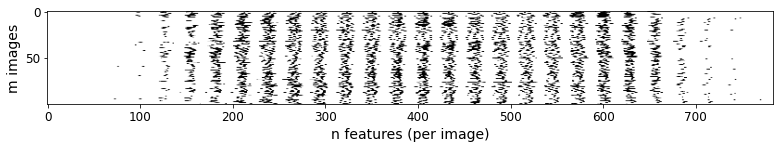

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# initiate figure
plt.figure(figsize=(13,10))

# plotting
plt.imshow(X_train[:100,:], cmap='binary')

# formating
plt.ylabel('m images')
plt.xlabel('n features (per image)')
#plt.axis('off')
plt.show()

Wir schauen uns nun ein Bild (Sample mit index ``21``) ganz genau an. Es besteht aus 784 Einträgen (Anzahl der Pixel). Da es sich um Schwarz-Weiß-Bilder handelt sind, hier nur die Helligkeiten (``0.``: weiß, ``255.``: schwarz) angegeben. 

Das sind die Features (784 Stück) zum Sample mit index ``21``.

In [7]:
# pick a digit
X_train[21]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

Wir wollen untersuchen, welche Ziffer sich hinter diesen Features verbirgt. Dazu werden die Features umgeordnet in 2D. 

Anmerkung: Das Bild muss nicht immer quadratisch sein. In diesem Datensatz ist das zufällig aber der Fall.

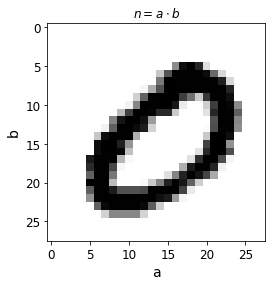

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# select a digit (here index 21)
digit_picked = X_train[21]

# reshape to 2D and plot
digit_picked_2D = digit_picked.reshape(28, 28)
plt.imshow(digit_picked_2D, cmap='binary')

# formating
plt.title('$n = a \cdot b$')
plt.ylabel('b')
plt.xlabel('a')

plt.show()

## 2.2 | Scikit-learn PCA - Feature Extraction MNIST Datensatz

<font color=red>**Anmerkung für das Berufungskommittee** 
    
In einer realen Lehrveranstaltung (die länger als 30 min dauert) würde dieser Abschnitt zuvor mit den Studierenden gemeinsam durchgeführt, um sich einen Überblick zu verschaffen. In der Probelehrveranstaltung wird dieser Teil nicht explizit durchgeführt (Konzentration auf Abschnitt 3). Sie finden eine Zusammenfassung dieses Abschnitts auf den Folien.</font>

Beispielsweise kann man mit Python Packages wie ``sklearn`` PCA sehr bequem in wenigen Zeilen durchführen. Zuerst schauen wir uns allerdings die Theorie hinter der PCA an (siehe Folien).

In [9]:
from sklearn.decomposition import PCA

pca = PCA(svd_solver='full')
pca.fit(X_train)

PCA(svd_solver='full')

Nachdem wir die Theorie verstanden haben, schauen wir uns die Ausgabe von ``pca`` genauer an.

In [10]:
# get cumulative variance of the PCs
cum_variance_of_PCs = np.cumsum(pca.explained_variance_ratio_)

# extract all PCs necessary to reach 95% variance of the original sample
d = np.argmax(cum_variance_of_PCs >= 0.95) + 1
print('Feature Extraction:', d)

Feature Extraction: 154


Die oben angezeigte Anzahl der Features beinhaltet nur die notwendigen PCs mit mind. 95% Varianz der ursprünglichen Daten. Unten ist die kumulative Verteilung in Abhängigkeit der Features gezeigt.

Saving figure BV_cumsum.png


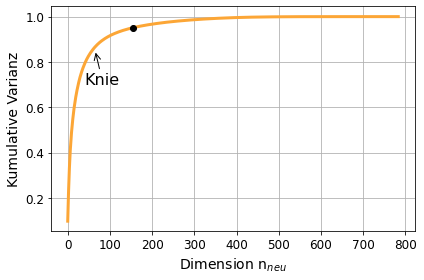

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# setup figure
plt.figure(figsize=(6,4))

# plot
plt.plot(cum_variance_of_PCs, color=mpl.cm.get_cmap('plasma')(0.8), linewidth=3)
#plt.axis([0, 800, 0, 1.01])

# formating
plt.xlabel(r"Dimension n$_{neu}$")
plt.ylabel("Kumulative Varianz")
plt.plot(d, 0.95, "ko")
plt.annotate("Knie", xy=(65, 0.85), xytext=(40, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
save_fig("BV_cumsum.png")
plt.show()

<font color=red>**Aufgabe:** Ermitteln Sie die Varianz bei 100 Features und überlegen Sie, ob es noch vertretbar ist, die Features weiter zu reduzieren?</font>

Es gibt eine Abkürzung in ``sklearn`` um die zu erreichende Varianz direkt einzugeben:

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, svd_solver='full')
X_reduced = pca.fit_transform(X_train)

Nun überprüfen wir, ob es funktioniert hat. Sind es wieder 154?

In [13]:
# new features (n_new)
pca.n_components_

154

Ist es wirklich mind. 95% Varianz?

In [14]:
# variance sum of used PCs to reach at least 0.95
np.sum(pca.explained_variance_ratio_)

0.9504326468621525

## 2.3 | Bildkompression (Bonus)

<font color=red>**Anmerkung für das Berufungskommittee** 
    
In einer realen Lehrveranstaltung (die länger als 30 min dauert) würde dieser Abschnitt mit den Studierenden gemeinsam durchgeführt, um sich einen Überblick zu verschaffen. In der Probelehrveranstaltung wird dieser Teil nicht explizit im Notebook durchgeführt. Sie finden eine Zusammenfassung dieses Abschnitts auf den Folien.</font>

Es ist möglich, die PCA umzudrehen (bei geringen Verlusten). Somit kann man Bilder komprimieren. Es wird dafür die "Inverse" der Matrix berechnet (siehe Skript). In ``sklearn`` funktioniert es so:

In [15]:
pca = PCA(n_components = 154, svd_solver='full')
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

Was hier passiert ist schauen wir uns in dem nächsten Diagramm an (dort gibt es 3 ``subplots``).

Saving figure BV_compress.png


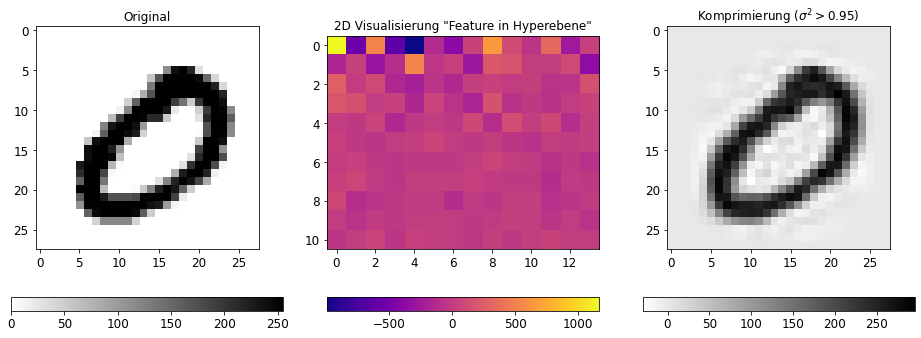

In [16]:
f = plt.figure(figsize=(13,5))

# plot original with index 21
f.add_subplot(131)
plt.title(r'Original')
plt.imshow(X_train[21].reshape(28,28), cmap='binary')
plt.colorbar(orientation='horizontal')

# plot 2D visualization of PCA reduced "image" with only 154 features
f.add_subplot(132)
plt.title('2D Visualisierung "Feature in Hyperebene"')
plt.imshow(X_reduced[21].reshape(11,14), cmap='plasma')
plt.colorbar(orientation='horizontal')

# plot compressed image
f.add_subplot(133)
plt.title(r'Komprimierung ($\sigma^2>0.95$)')
plt.imshow(X_recovered[21].reshape(28,28), cmap='binary')
plt.colorbar(orientation='horizontal')
save_fig("BV_compress.png")

* Links: Originales Bild zu Index 21 (28x28) entspricht 784 Pixel (Features)
* Mitte: PCA extrahierte Features entspricht 154 Pixel (ist nicht mehr quadratisch!!!) In der 2D Visualisierung sieht man, dass man keine Ziffer mehr erkennen kann. Wir befinden uns jetzt auf der Hyperebene.
* Rechts: Komprimiertes Bild mit erhaltener Varianz von mind. 95% (Beachten Sie die negativen Werte.)

Der unten angegebene Code (Geron 2019) gibt mehrere Beispielziffern aus:

Saving figure mnist_compression_plot


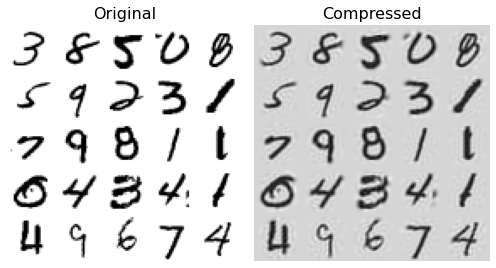

In [17]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

save_fig("mnist_compression_plot")

# 3 | Qualität PCA Feature Extraction

<font color=red>**Anmerkung für das Berufungskommittee** 
    
Dieser Abschnitt wird exemplarisch (für die anderen Abschnitte) live mit den Studierenden durchgeführt. Die Studierenden haben das gleiche Notebook zur Hand, und können es selbst zeitgleich ausführen. </font>

Wir benutzen den bereits geladenen MNIST Datensatz (siehe Abschnitt 2) und teilen ihn in Training- und Testset auf (6:1).

In [18]:
X_train = mnist['data'][:60000]
y_train = mnist['target'][:60000]

X_test = mnist['data'][60000:]
y_test = mnist['target'][60000:]

In [19]:
X_train.shape

(60000, 784)

Wir nutzen ``sklearn`` um am MNIST Datensatz Feature Extraction mit der PCA Methode durchzuführen. Wir stellen eine zu erreichende Mindestvarianz von 95% ein.

**Anmerkung:** Falls Sie zuvor Abschnitt 2 durchgeführt haben, muss mit den neuen ``X_train`` auch die PCA erneut durchgeführt werden.

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, svd_solver='full')
X_train_reduced = pca.fit_transform(X_train)



Im Folgenden werden wir 2 verschiedene Classifier (RFC & softmax) mit den Trainingsset trainieren. Dabei messen wir Folgendes:

* Trainieren mit dem originalen Datensatz (Matrix $A$)
    * Zeit
    * Genauigkeit
    
* Trainieren mit dem feature-extracted Datensatz (Matrix $A_E$)
    * Zeit
    * Genauigkeit

In [21]:
import time

## 3.1 | Stoppuhr für RandomForestClassifier (RFC)
### 3.1.1 | RFC ohne PCA

<font color=red>**Aufgabe:** Stoppen Sie die Zeit, die ein RandomForestClassifier braucht um Ihr Trainingset zu bearbeiten. Mit welcher Genauigkeit ist zu rechnen?</font>

In [22]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=20, random_state=42)

# start clock
t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()

print('Stoppuhr {:.2f}s'.format(t1 - t0))

Stoppuhr 8.80s


In [23]:
from sklearn.metrics import accuracy_score
y_pred = rnd_clf.predict(X_test)

print('Genauigkeit {:.2f}'.format(accuracy_score(y_test, y_pred)))

Genauigkeit 0.96


Um vergleichen zu können, brauchen wir auch noch das Training mit $A_E$ (PCA Variante).

### 3.1.2 | RFC mit PCA

<font color=red>**Aufgabe:** Wiederholen Sie die letzte Aufgabe, nutzen Sie aber diesesmal ``X_train_reduced``?</font>

In [24]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf2 = RandomForestClassifier(n_estimators=20, random_state=42)

# start clock
t0 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

print('Stoppuhr {:.2f}s'.format(t1 - t0))

Stoppuhr 19.26s


<font color=red> **Oh!** </font>Das hat mehr als doppelt so lange gedauert. Überlegen Sie warum?

Bedenken Sie, dass Feature Extraction nicht immer zur Beschleunigung führt, da die Performace eng mit folgenden Faktoren zusammenhängt:

* Art des Datensatzes (Mannigfaltigkeit?)
* Art des Feature Extraction Modells (linear?, nicht linear?)
* Art des Trainingalgorithmus

Wie sieht es mit der Genauigkeit aus?

In [25]:
X_test_reduced = pca.transform(X_test)
y_pred = rnd_clf2.predict(X_test_reduced)

print('Genauigkeit {:.2f}'.format(accuracy_score(y_test, y_pred)))

Genauigkeit 0.93


**Fazit: Kombination von PCA und RFC führen bei diesem Datensatz (MNIST) zu einer Verschlechterung in Zeit und Genauigkeit.**

## 3.2 | Stoppuhr für softmax

<font color=red> **Aufgabe:** Wir wiederholen die letzten zwei Aufgaben nun für ``LogisticRegression`` (softmax). Die Unterschiede zwischen ``softmax`` und ``RFC`` **interessieren uns momentan nicht**. Dazu müssten wir auch realistischere Parameter wählen, was dann aber sehr viel länger dauern würde. 
    
**Uns interessiert** momentan nur der Effekt, den wir erhalten, wenn wir PCA zusätzlich anwenden.</font>
### 3.2.1 | softmax ohne PCA

In [26]:
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)#, max_iter=100)

t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()

print('Stoppuhr {:.2f}s'.format(t1 - t0))

Stoppuhr 10.69s


/Users/koepferl/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
y_pred = log_clf.predict(X_test)
print('Genauigkeit {:.2f}'.format(accuracy_score(y_test, y_pred)))

Genauigkeit 0.93


### 3.2.2 | softmax mit PCA 

In [28]:
log_clf2 = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)#, max_iter=300)
t0 = time.time()
log_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

print('Stoppuhr {:.2f}s'.format(t1 - t0))

Stoppuhr 4.66s


/Users/koepferl/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Viel weniger Rechenzeit!

In [29]:
y_pred = log_clf2.predict(X_test_reduced)
print('Genauigkeit {:.2f}'.format(accuracy_score(y_test, y_pred)))

Genauigkeit 0.92


Sehr kleine Abweichung in der Genauigkeit.

**Fazit: PCA kann bei tolerierbaren Verlusten die Rechenzeit verkürzen - aber nicht immer**

Zurück zu den Folien, bevor wir uns Abschnitt 4 ansehen können.

# 4 | Visualisierung des MNIST Datensatz (d=2)

<font color=red>**Anmerkung für das Berufungskommittee** 
    
In einer realen Lehrveranstaltung (die länger als 30 min dauert) würde dieser Abschnitt mit den Studierenden gemeinsam durchgeführt und diskutiert. In der Probelehrveranstaltung wird dieser Teil nicht explizit durchgeführt (Konzentration auf Abschnitt 3). Sie finden eine Zusammenfassung dieses Abschnitts auf den Folien.</font>

Im Folgenden reduzieren wir die Features auf nur 2 Stück. Dann ist $d=2$, was sehr hilfreich bei der Visualisierung ist. Das kann aber auch schiefgehen, wie wir gleich sehen werden.

#### Lade Datensatz

In [30]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

#### Wähle nur 10.000 Permutationen aus 
(sonst dauert es sehr sehr lang)

In [31]:
np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx]

<font color=red> **Aufgabe:** Wir nutzen nun t-SNE aus den MNIST Datensatz um nur 2 Features zu extrahieren. Dies ist nützlich u. a. bei der Visualisierung und der Klassifizierung.</font>

Wir werden auch wieder die Zeit stoppen.

## PCA : Stoppuhr

In [32]:
import time
from sklearn.decomposition import PCA

t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42, svd_solver='full').fit_transform(X)
t1 = time.time()
print('PCA Stoppuhr {:.1f}s.'.format(t1 - t0))

PCA Stoppuhr 1.3s.


Wieder sehr schnell! 

Nun schauen wir uns die 2D Verteilung an. 

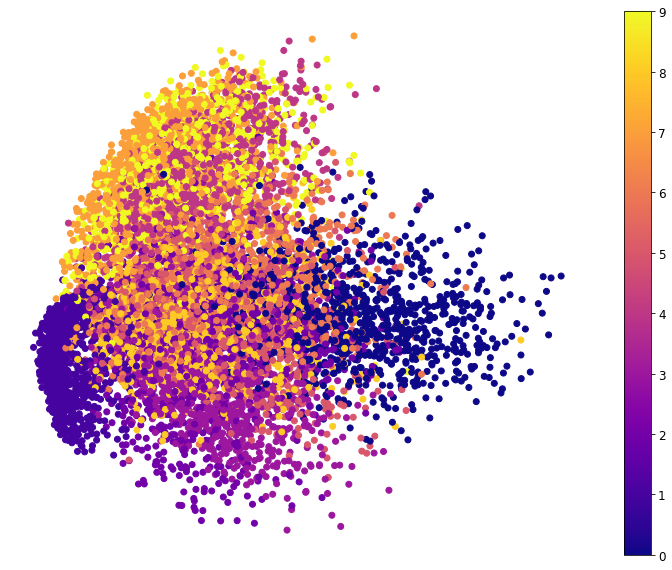

In [33]:
# default scatter plot
plt.figure(figsize=(13,10))
plt.scatter(X_pca_reduced[:, 0], X_pca_reduced[:, 1], c=y, cmap="plasma")
plt.axis('off')
plt.colorbar()
plt.show()

Wir sehen, dass sehr viele Punkt übereinander liegen. 

Wir können den Plot mit der unten angegebenen Routine schöner machen, ...

In [34]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, numbers=None, figsize=(13, 10), cmap='plasma'):
    
    # scale the input features from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    neighbors = np.array([[10., 10.]])
    
    # setting up figure and colormap
    plt.figure(figsize=figsize)
    mymap = mpl.cm.get_cmap(cmap)
    cmap = mpl.colors.ListedColormap([mymap(f/10.) for f in range(10)])
    
    # loop over all 10 digits 0 to 9
    digits = np.unique(y)
    for digit in digits:
        if numbers is not None:
            scatter = plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], 
                                  marker='$' + str(digit) + '$', c=y[y==digit], s=numbers, cmap=cmap, vmin=-0.5, vmax=9.5)
        else:
            scatter = plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], 
                                  c=y[y==digit], vmin=-0.5, vmax=9.5, cmap=cmap)
    
    # setting up colorbar and remove axis
    cb = plt.colorbar(scatter, ticks=np.linspace(0,9,10), pad=0., orientation='horizontal')
    cb.ax.tick_params(labelsize=24)
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    
    # calculation of the distances and plotting of the text or images
    if numbers is None:
        for index, image_coord in enumerate(X_normalized):
            closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
            if closest_distance > min_distance:
                neighbors = np.r_[neighbors, [image_coord]]
                
                if images is None:
                    plt.text(image_coord[0], image_coord[1], str(int(y[index])),color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
                else:
                    image = images[index].reshape(28, 28)
                    imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)

                    ax.add_artist(imagebox)

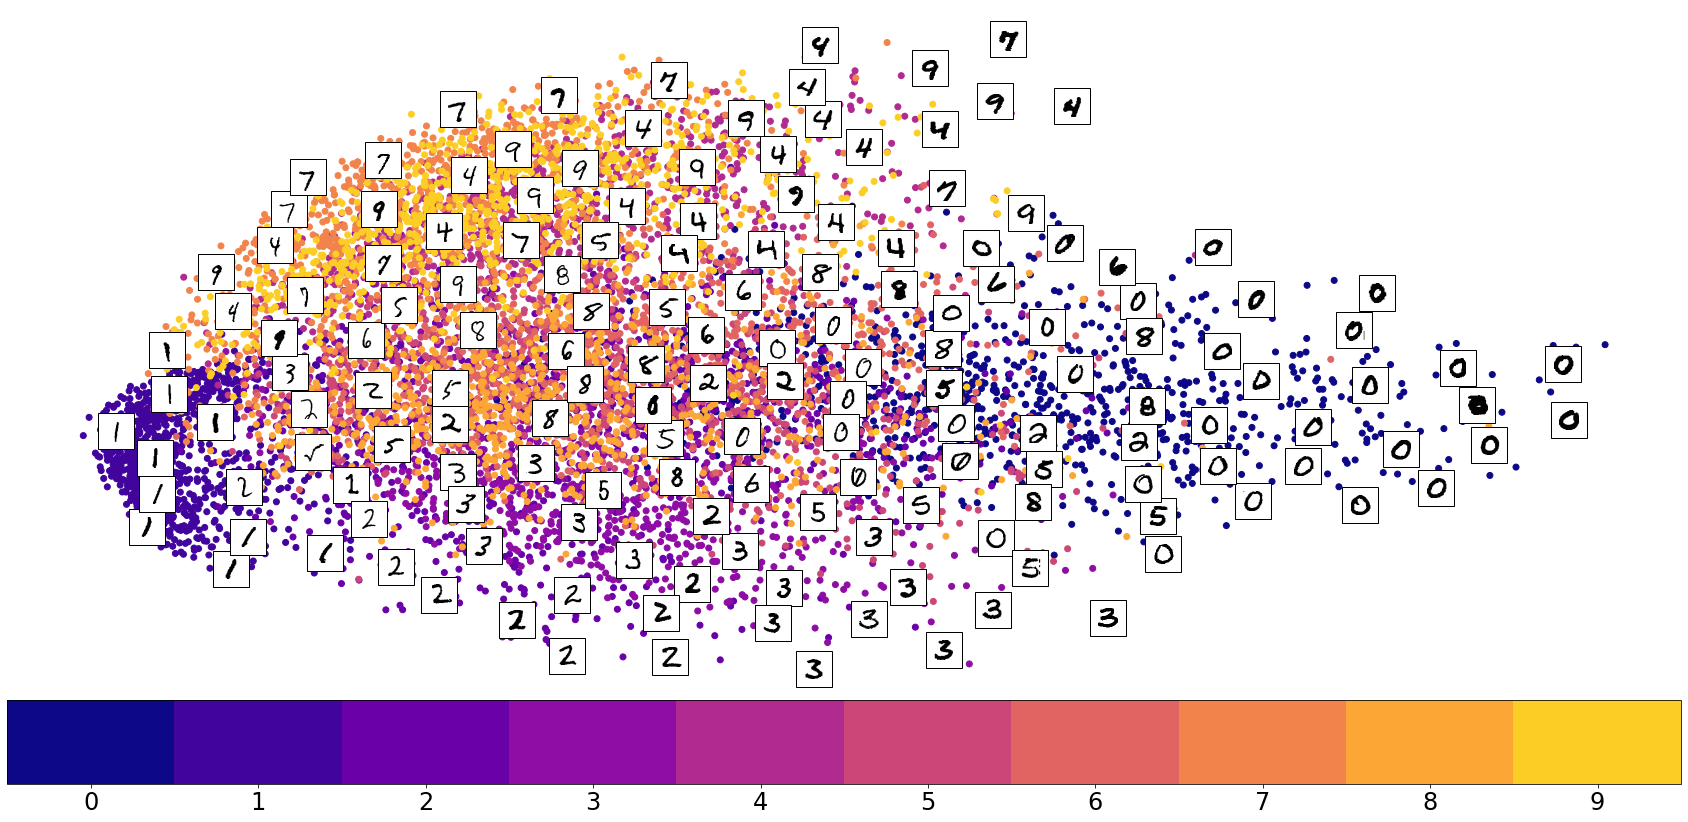

In [35]:
plot_digits(X_pca_reduced, y, images=X, figsize=(30, 15))

... allerdings liefert PCA alleine für diesen Datensatz keine brauchbare Visualisierung. Wir sehen zwar ein paar Cluster, aber es ist doch eine zu große Überlagerung.

Der Grund dafür ist, das PCA sehr gut funktioniert um überflüssige Dimensionenen (Features) zu reduzieren. Gibt es aber keine überflüssigen Dimensionen (wie bspw. bei einer vorliegenden Mannigfaltigkeit), wird zuviel reduziert. Das ist bei $d=2$ sehr gut zu erkennen.

Es ist nun Zeit, das wir eine Mannigfaltigkeitsmethode testen (t-SNE, Theorie in der nächsten Stunde).

## t-SNE : Stoppuhr

In [36]:
from sklearn.manifold import TSNE

t0 = time.time()
X_tsne_reduced = TSNE(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print('t-SNE Stoppuhr {:.1f}s.'.format(t1 - t0))

t-SNE Stoppuhr 193.2s.


Im Vergleich zur PCA dauert t-SNE sehr lange. Dafür bekommen wir auch ein schöneres Ergebnis.

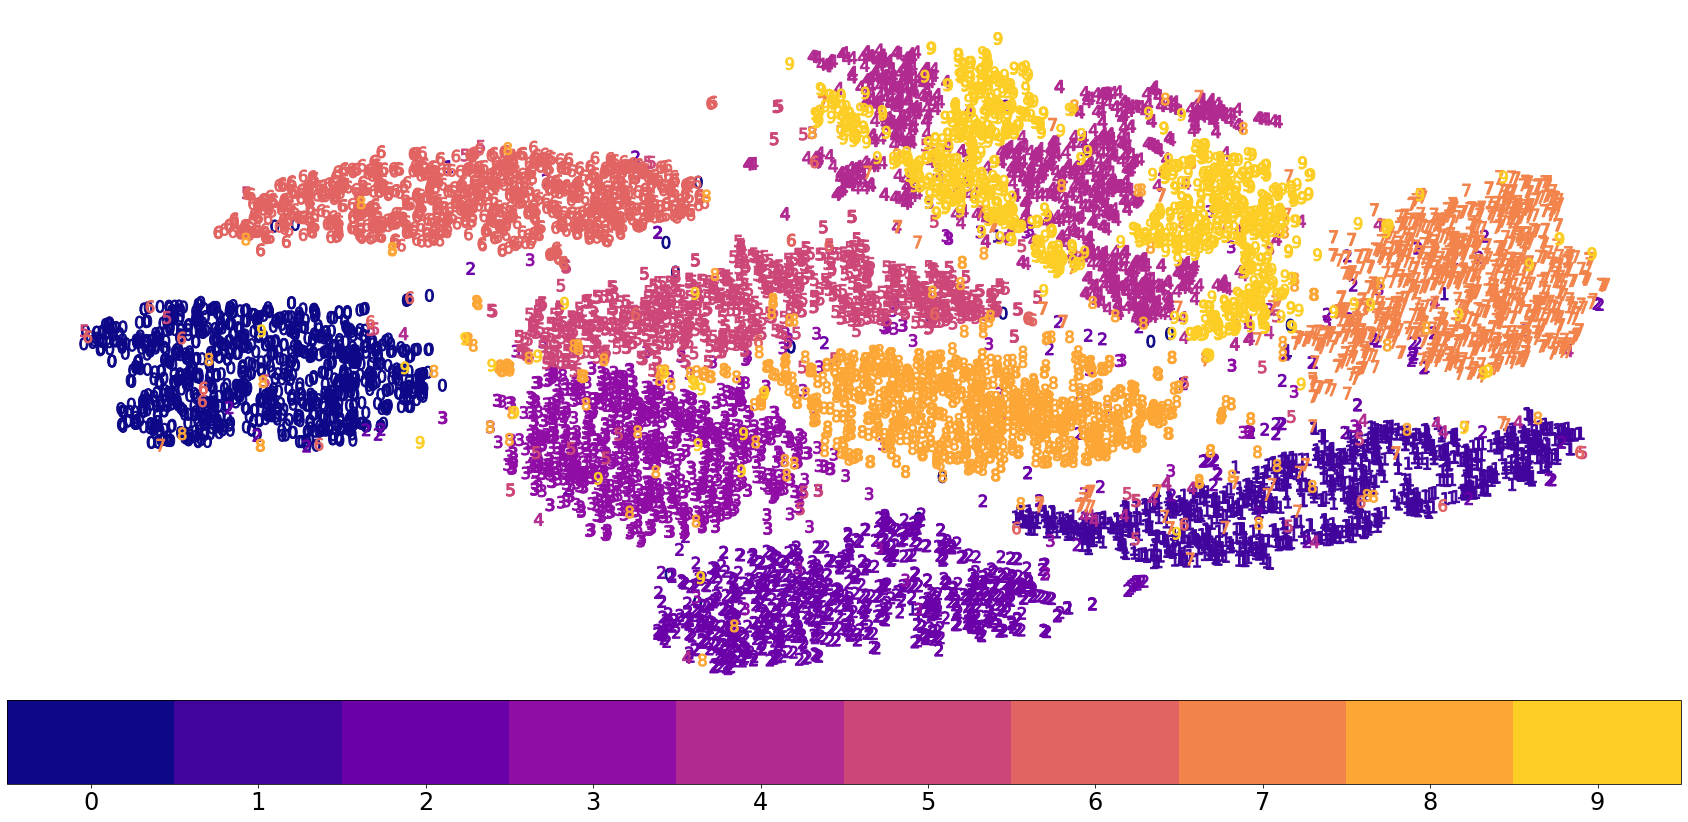

In [37]:
# only numbers
plot_digits(X_tsne_reduced, y, numbers=150, images=None, figsize=(30, 15))

Im Vergleich zur PCA alleine (oben) eine bessere Visualisierung. Wir können sehen, dass die Ziffern 0 und 6 separiert sind. Allerdings sieht man auch, dass beispielsweise 4 und 9 und manchmal 3 und 5 schwer auseinander zu halten sind. 

Unten sehen Sie noch andere Darstellungsvarianten.

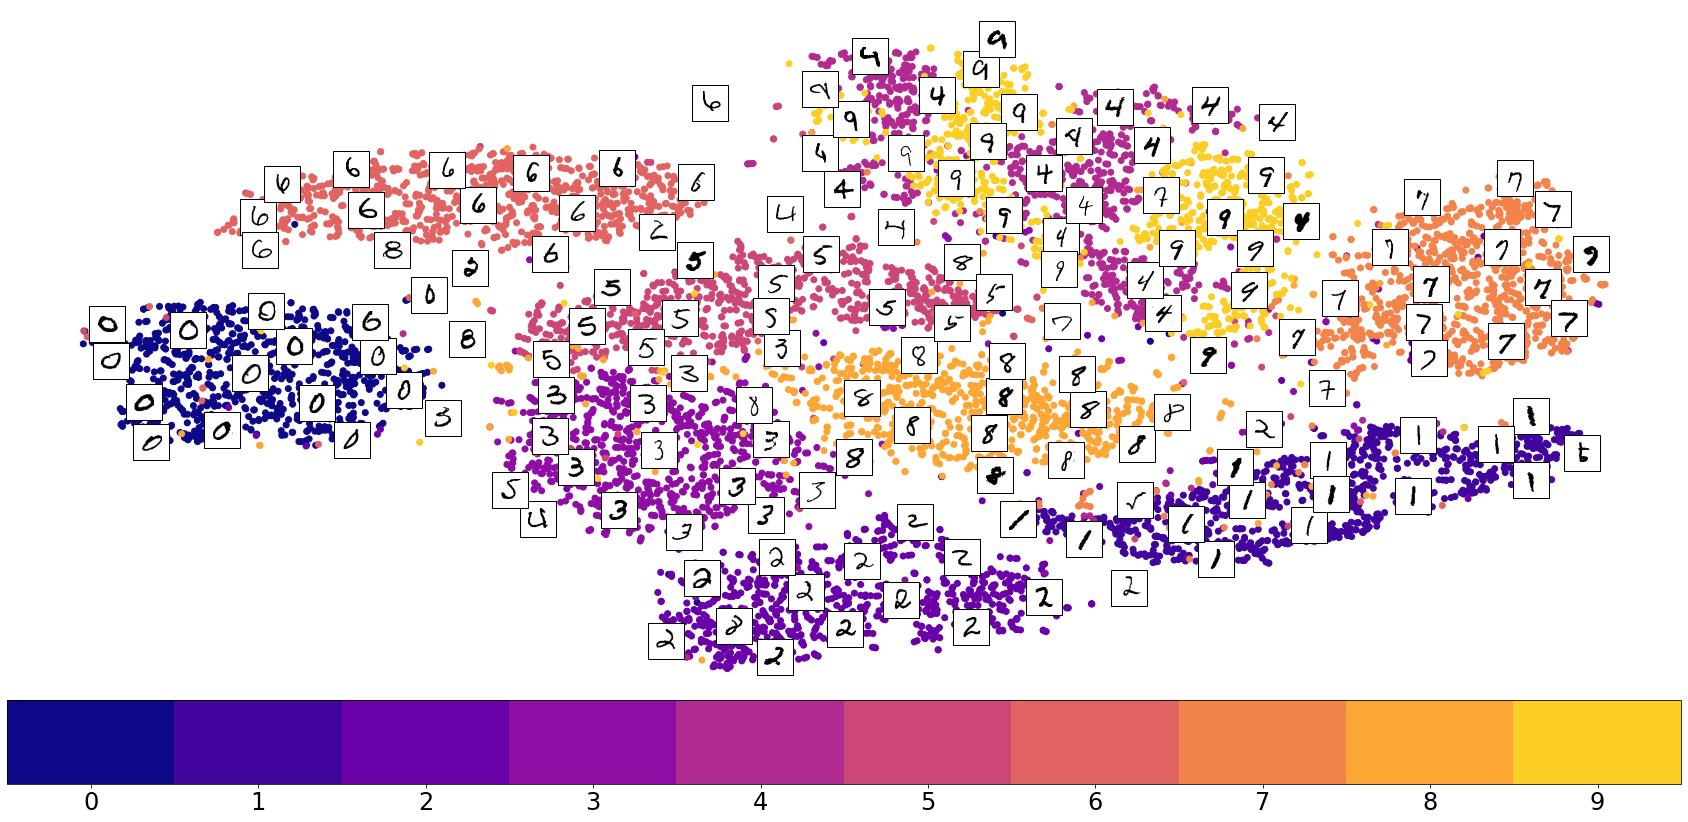

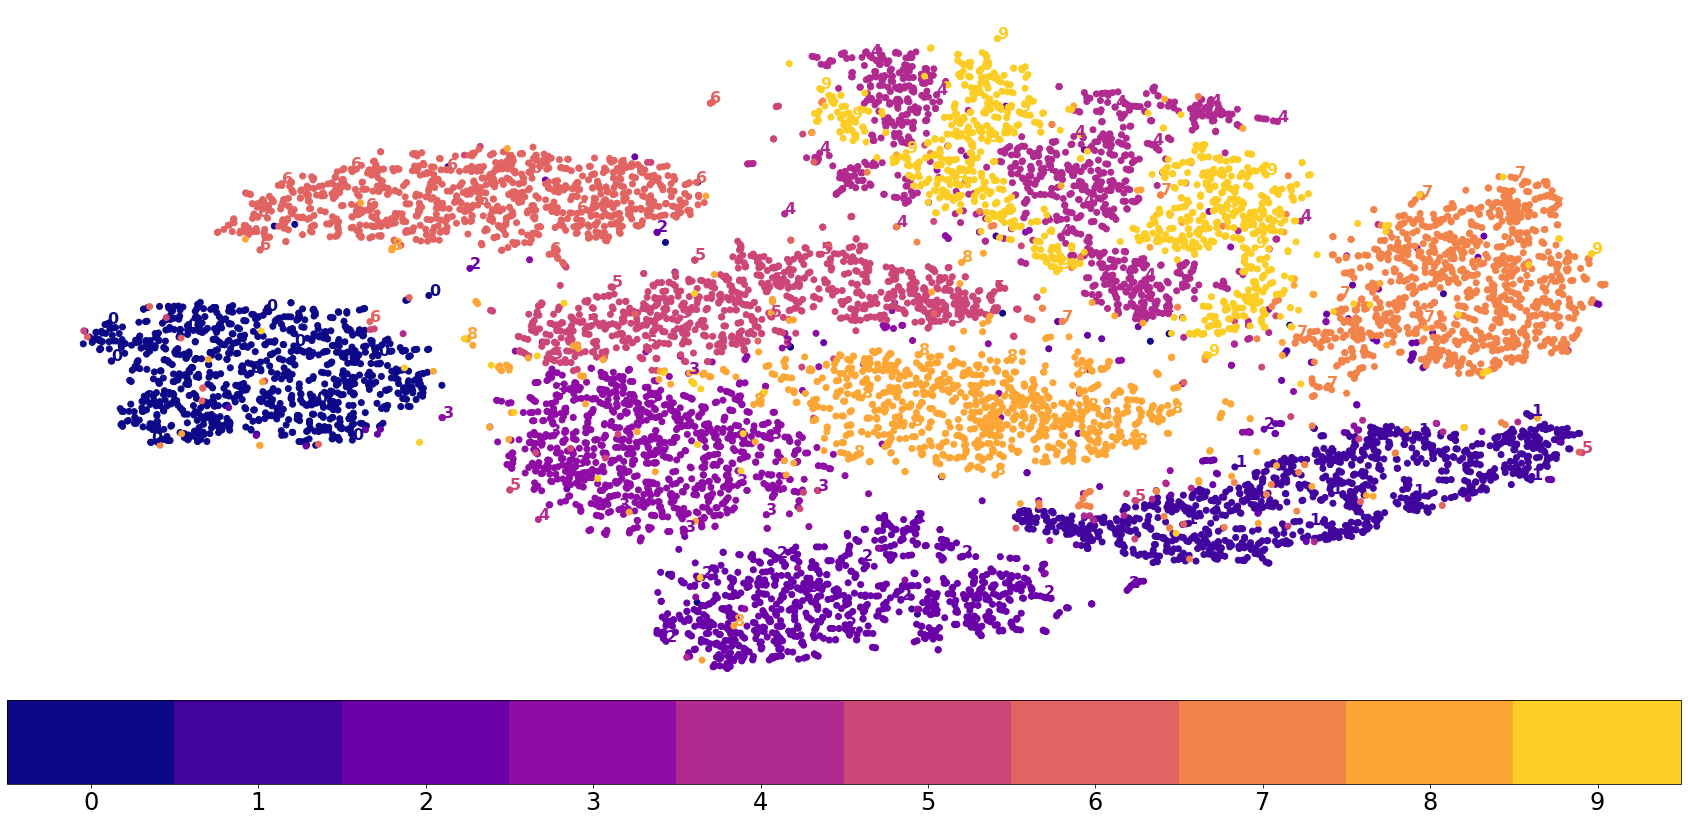

In [38]:
# only images
plot_digits(X_tsne_reduced, y, numbers=None, images=X, figsize=(30, 15))
# few numbers
plot_digits(X_tsne_reduced, y, numbers=None, images=None, figsize=(30, 15))

## PCA & t-SNE : Stoppuhr

Wenn wir PCA und t-SNE kombinieren, kann das in einer Pipeline geschehen.

In [39]:
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline


pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42, svd_solver='full')),
    ("tsne", TSNE(n_components=2, random_state=42)),
])

t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()

print('PCA + t-SNE Stoppuhr {:.1f}s.'.format(t1 - t0))

PCA + t-SNE Stoppuhr 132.4s.


Die Zeitersparnis liegt bei ca. 1/3 bei ähnlichem Ergebnis.

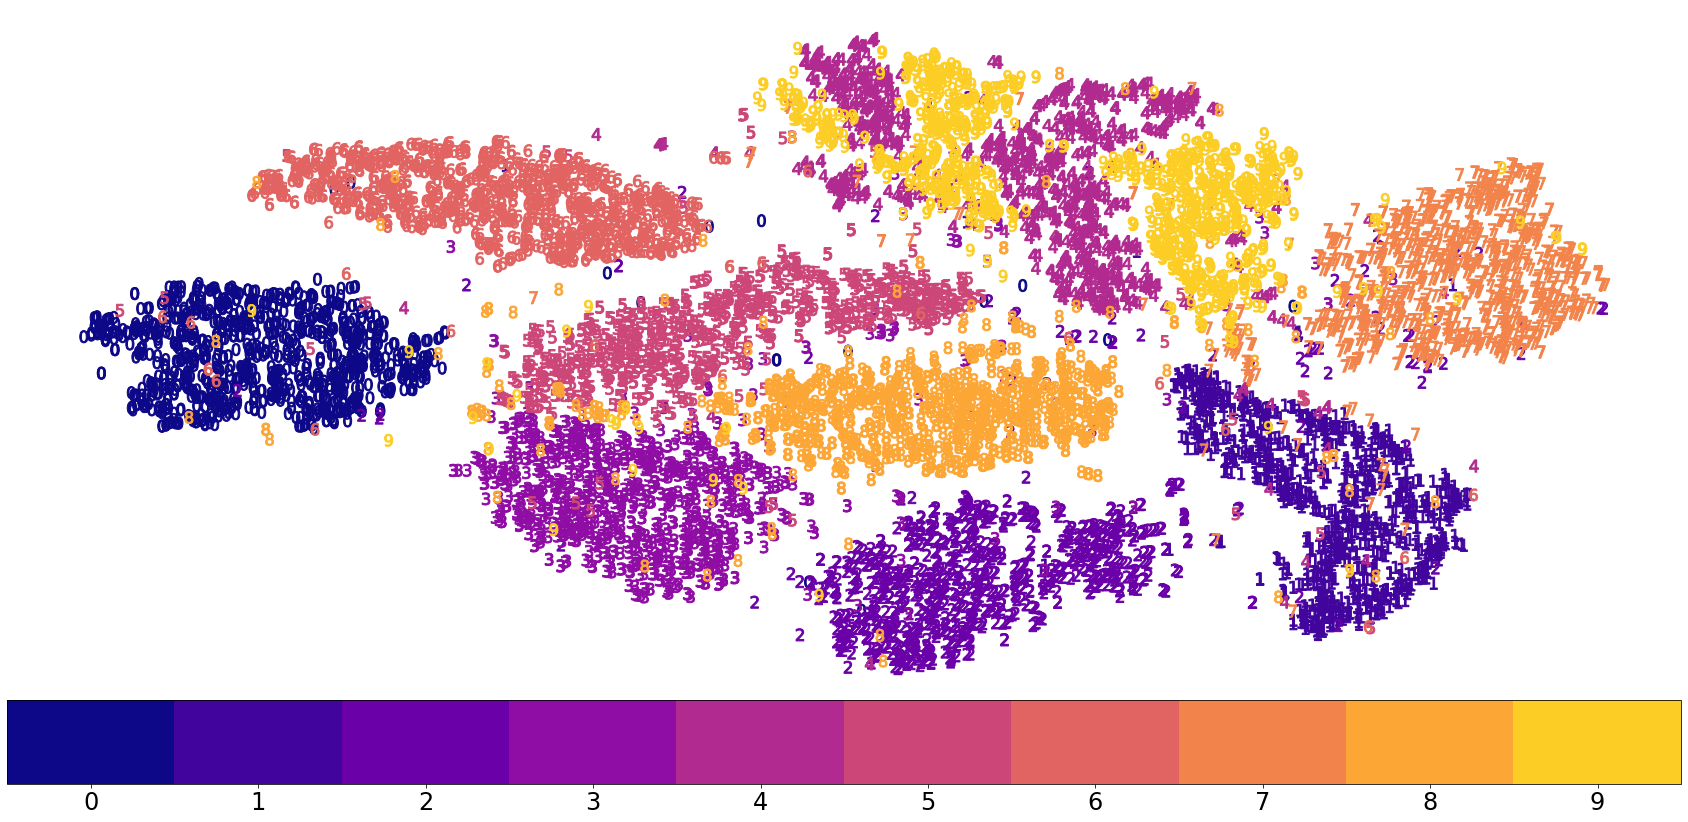

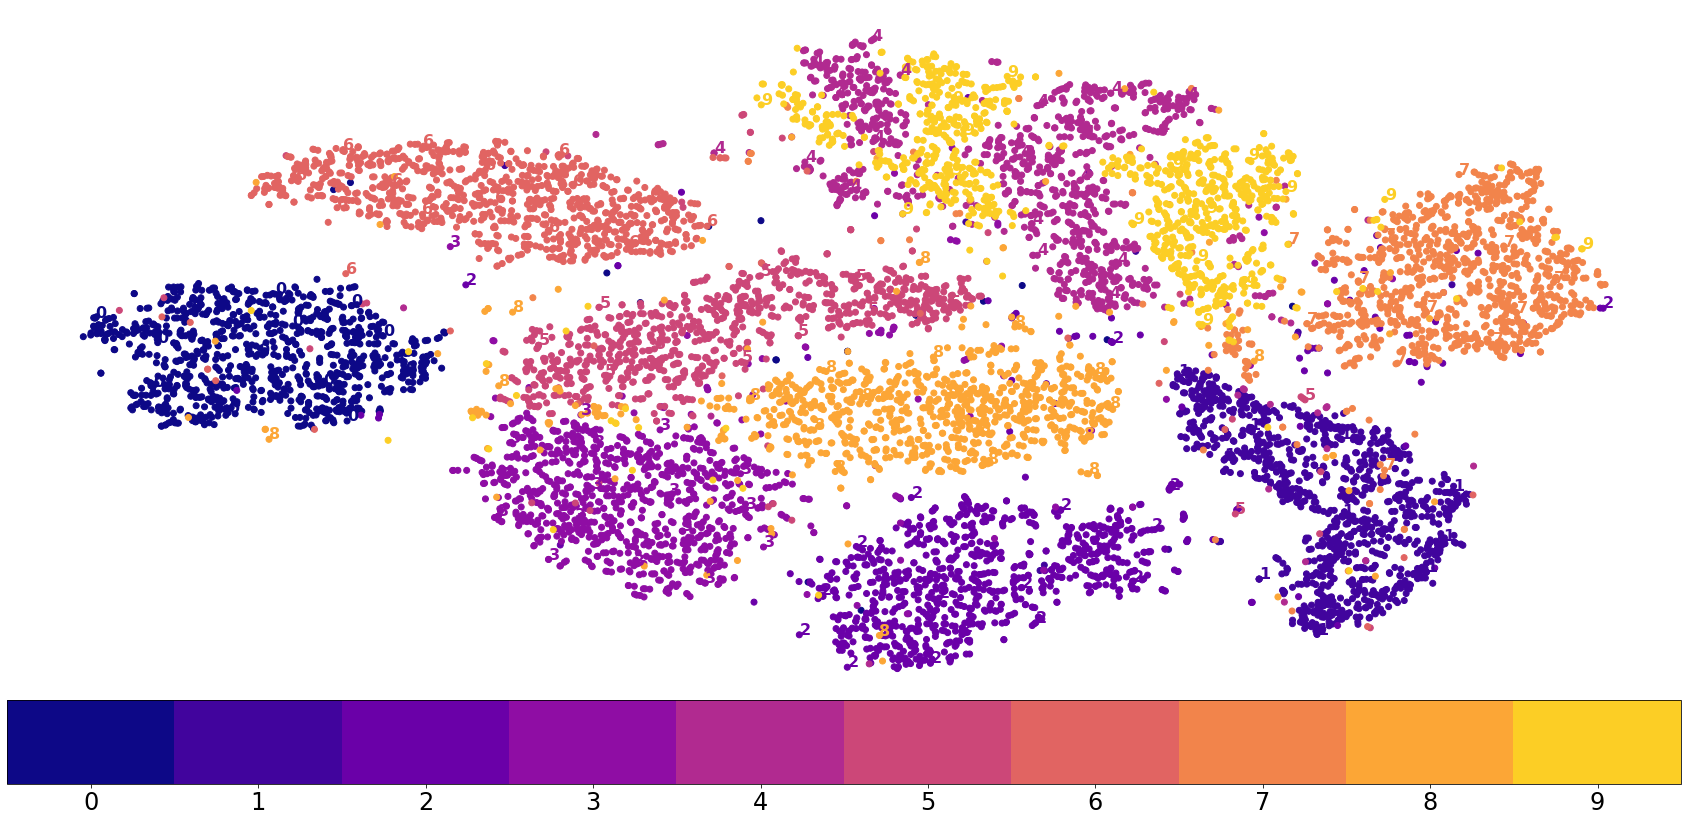

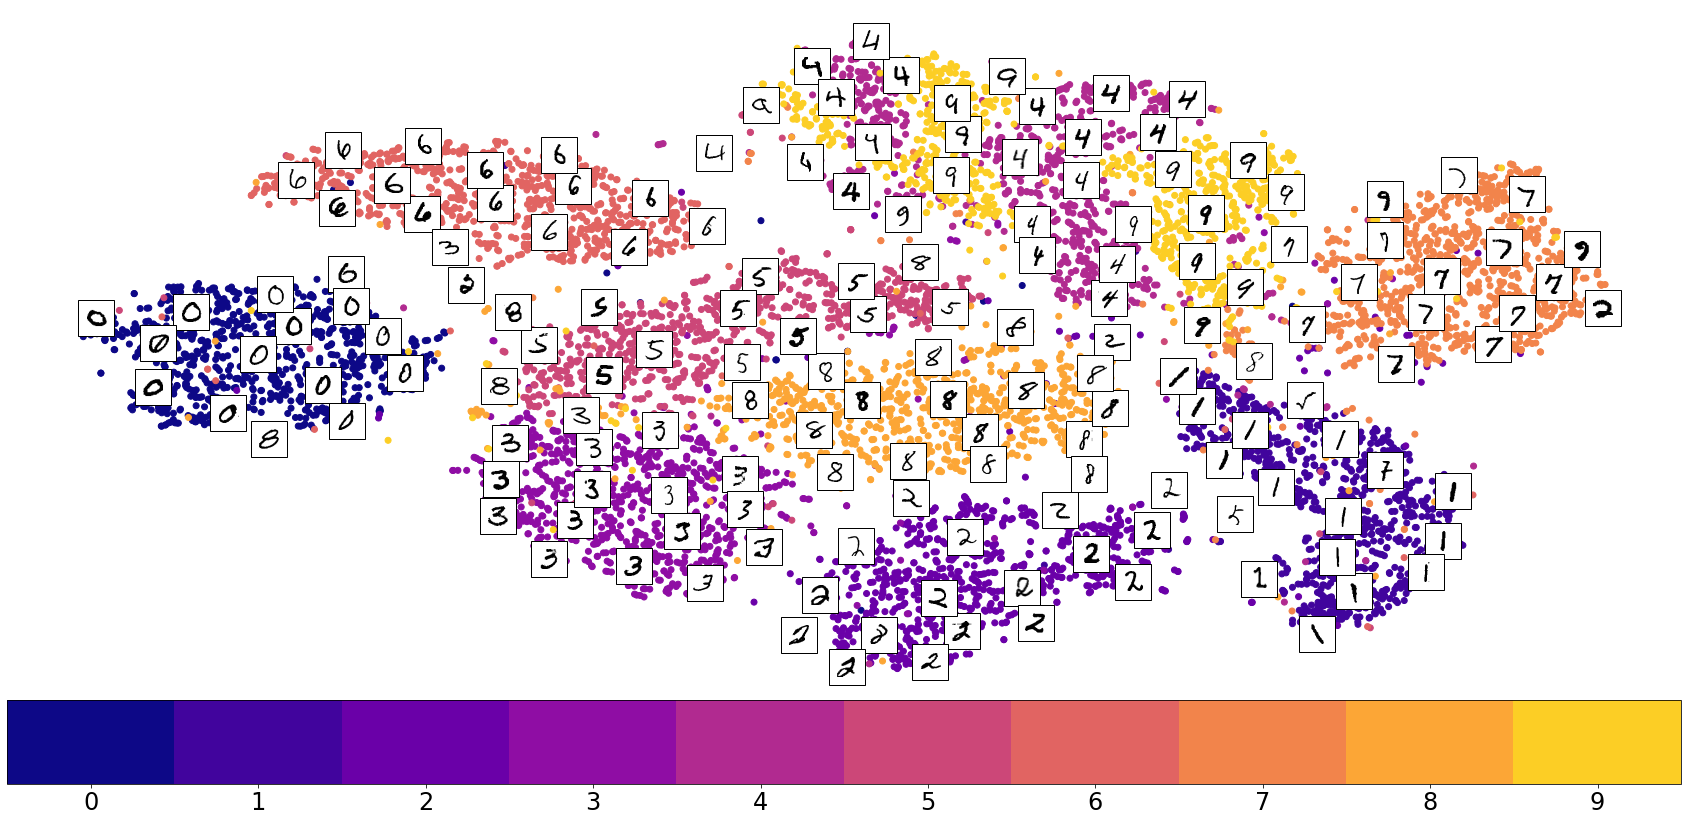

In [40]:
# only numbers
plot_digits(X_pca_tsne_reduced, y, numbers=150, images=None, figsize=(30, 15))
# few numbers
plot_digits(X_pca_tsne_reduced, y, numbers=None, images=None, figsize=(30, 15))
# only images
plot_digits(X_pca_tsne_reduced, y, numbers=None, images=X, figsize=(30, 15))

## 5 | Hausaufgabe

* 1) Die Cluster von 3en und 5en liegen sehr nahe beisammen. Plotten Sie 2en, 3en und 5en in ein separates Diagramm. 
* 2) Überprüfen Sie, ob die Visualisierung sich verbessert, wenn Sie die t-SNE nur für diese drei Ziffern laufen lassen.
* 3) Untersuchen Sie auch die unterschiedlichen Darstellungen anhand dieses Problems. Was folgern Sie?
* 4) Untersuchen Sie, ob PCA alleine für die Ziffern 0, 1, 4 besser funktioniert. Diskutieren Sie das Ergebnis.




In [41]:
# put your code here




#### zu 1) Es gibt eine starke Streuung

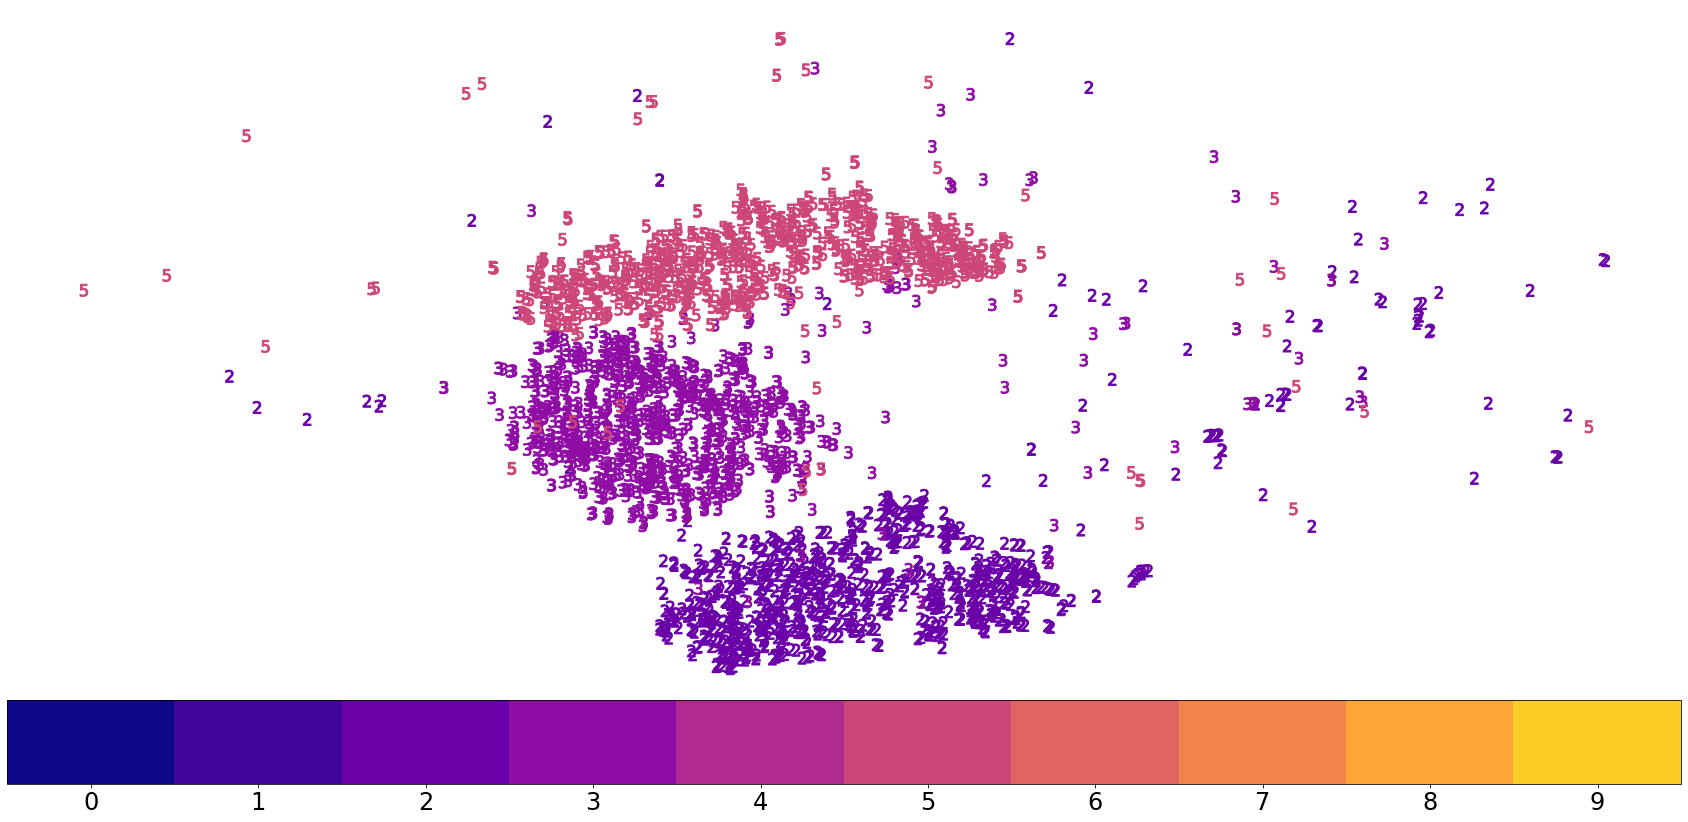

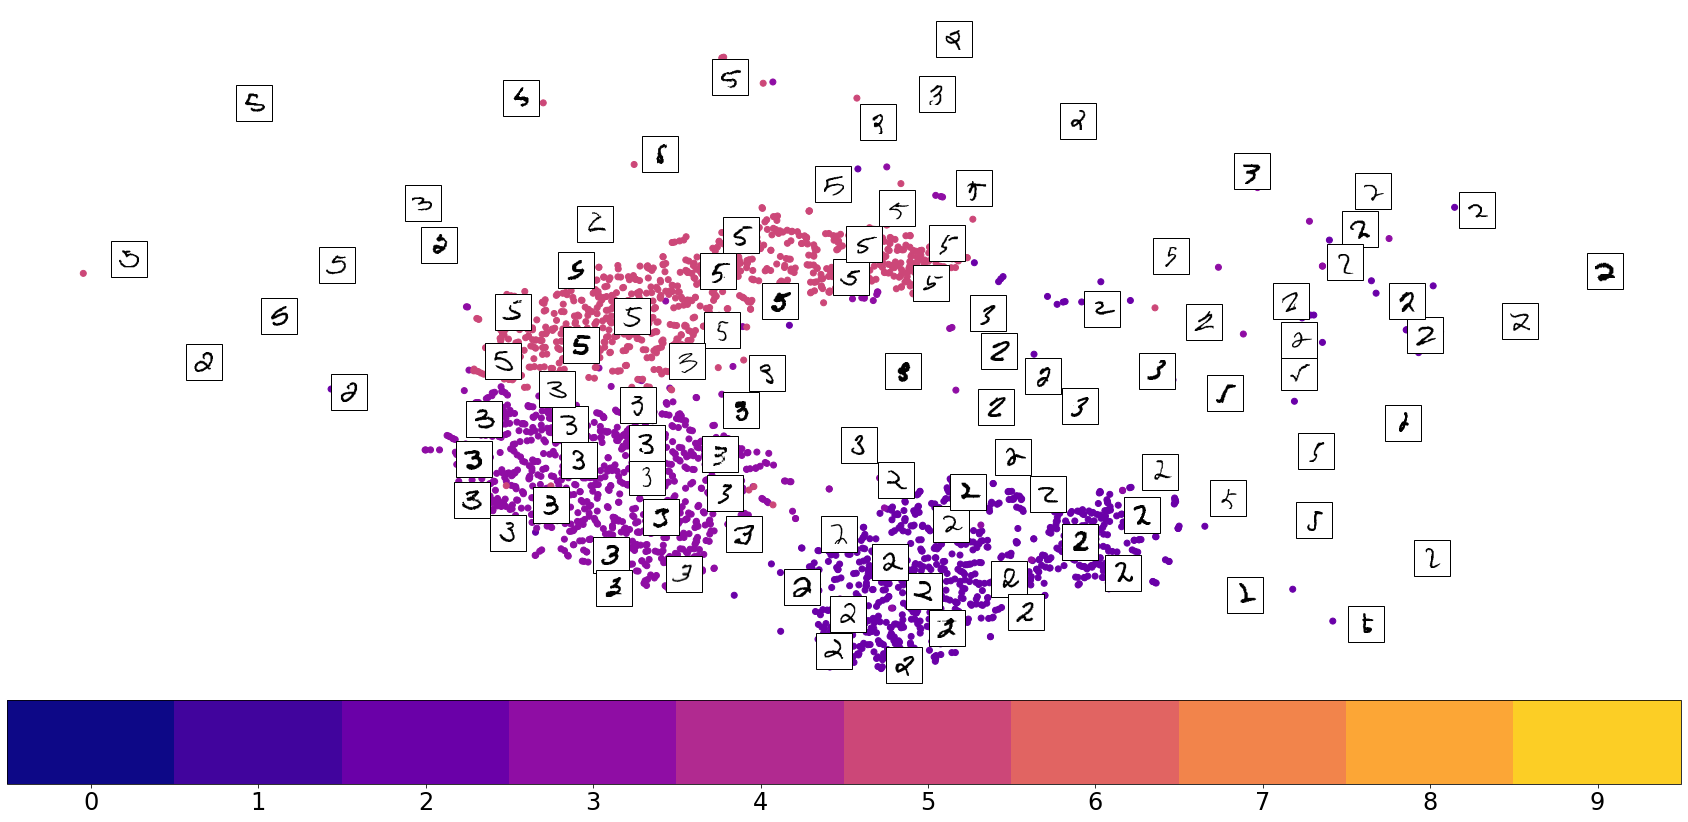

In [42]:
idx235 = (y == 2) | (y == 3) | (y == 5) 

# only numbers
plot_digits(X_tsne_reduced[idx235], y[idx235], numbers=150, images=None, figsize=(30, 15))
# only images
plot_digits(X_pca_tsne_reduced[idx235], y[idx235], numbers=None, images=X[idx235], figsize=(30, 15))

#### zu 2) und 3) Nun sind die Cluster stärker separiert

In [43]:
X_subset235 = X[idx235]
y_subset235 = y[idx235]

tsne_subset = TSNE(n_components=2, random_state=42)
X_subset_reduced235 = tsne_subset.fit_transform(X_subset235)

Unterschiedliche Darstellungen

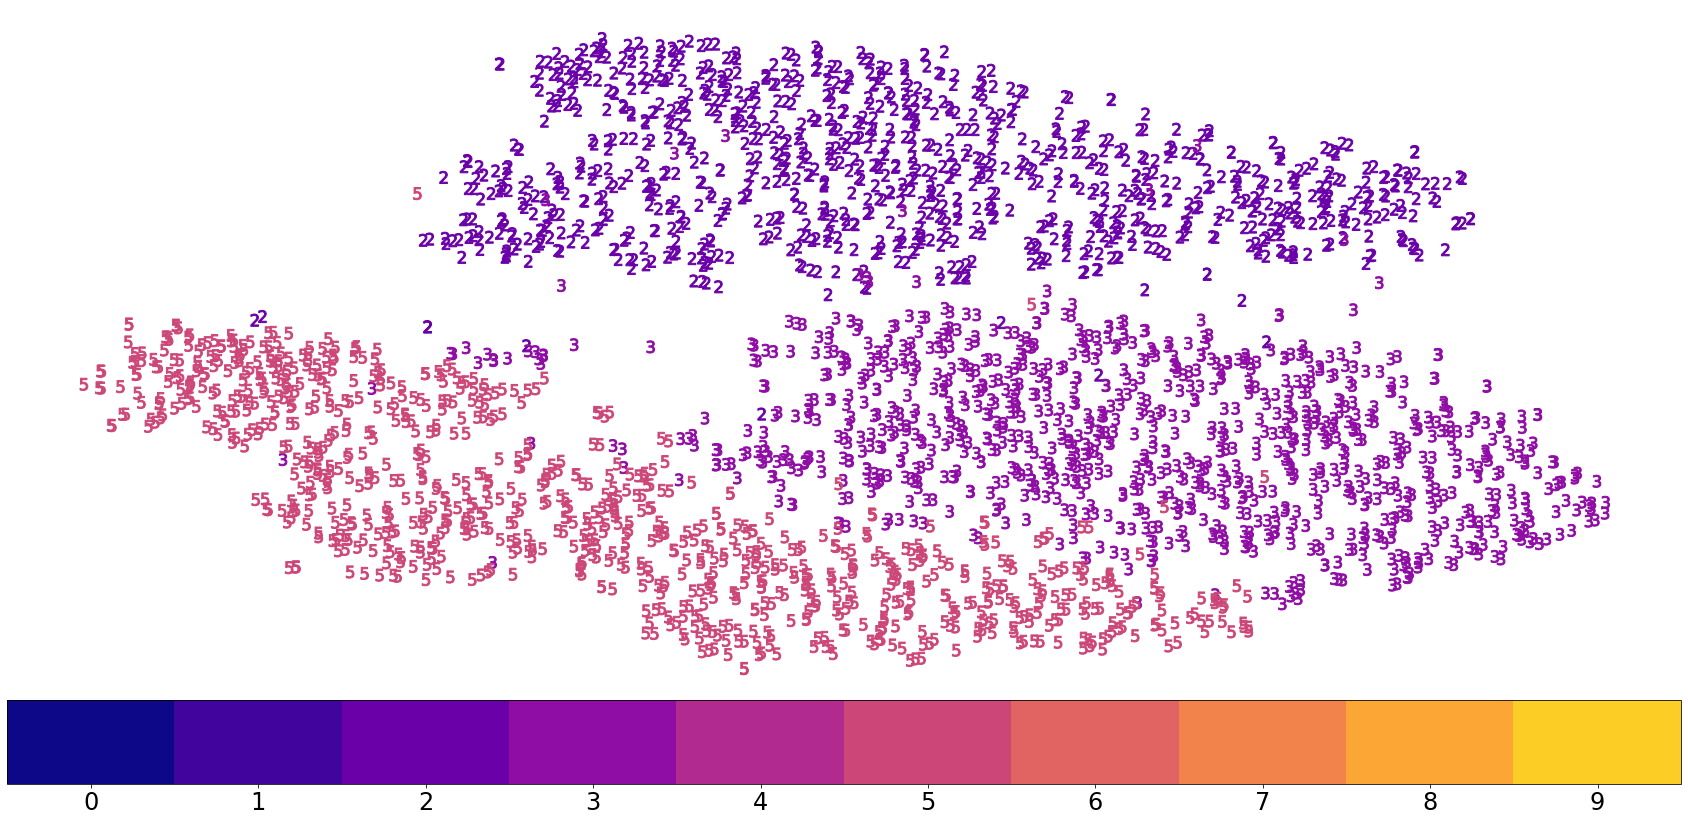

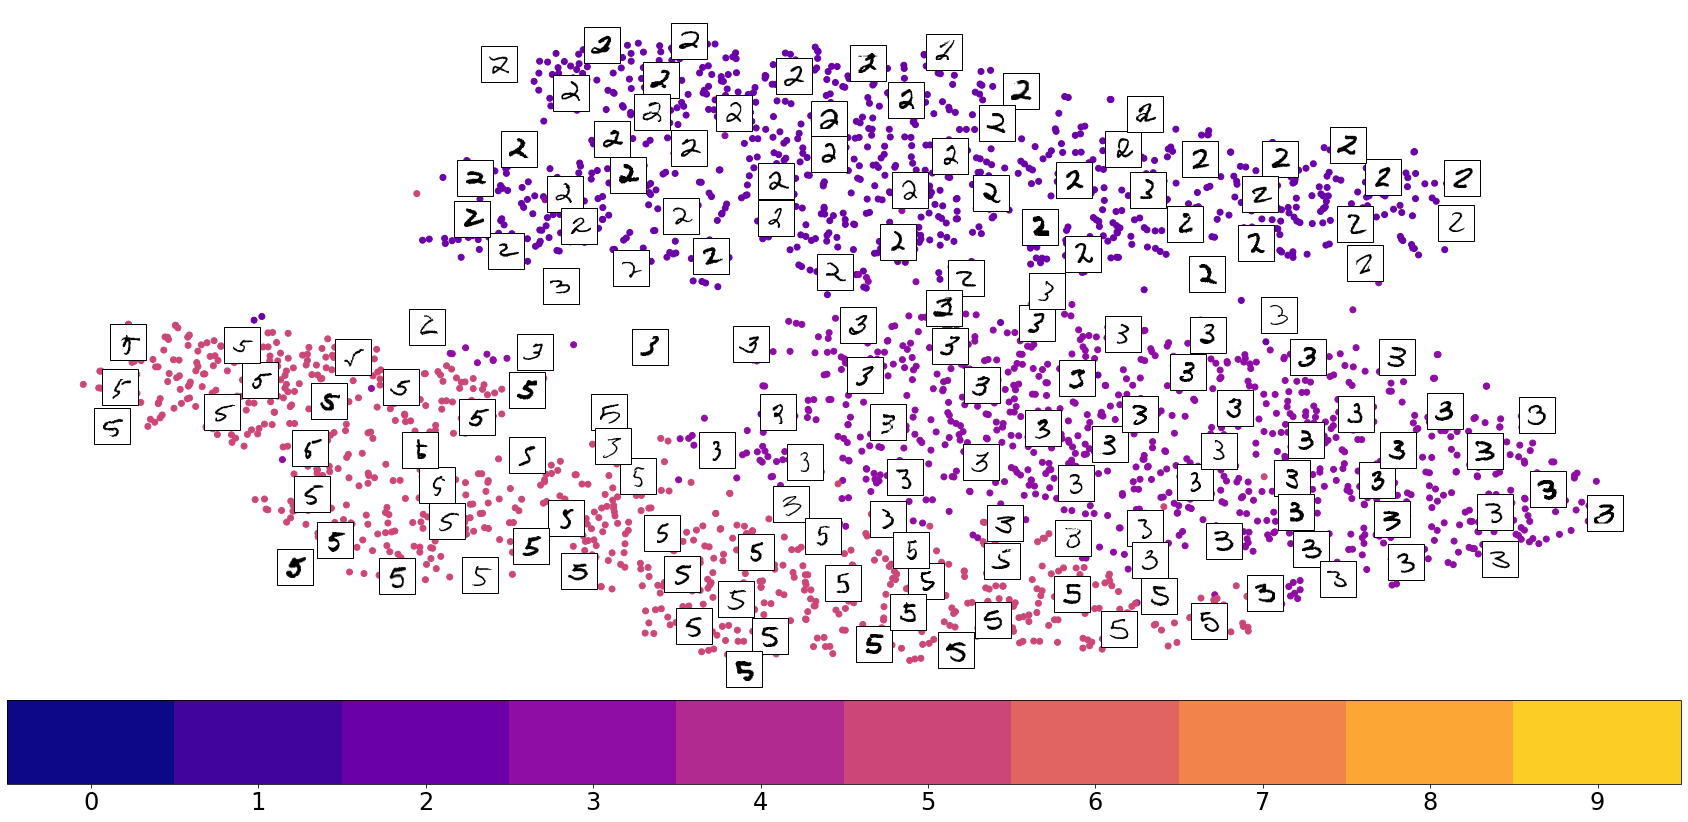

In [44]:
# only numbers
plot_digits(X_subset_reduced235, y_subset235, numbers=150, images=None, figsize=(30, 15))
# only images
plot_digits(X_subset_reduced235, y_subset235, numbers=None, images=X[idx235], figsize=(30, 15))

Es gibt zwei Cluster bei den 2en mit Kringel (links) und ohne Kringel (rechts). 

#### zu 4) PCA für Ziffern 0, 1, 4

In [45]:
idx014 = (y == 0) | (y == 1) | (y == 4) 

X_subset014 = X[idx014]
y_subset014 = y[idx014]

X_pca_reduced014 = PCA(n_components=2, random_state=42, svd_solver='full').fit_transform(X_subset014)

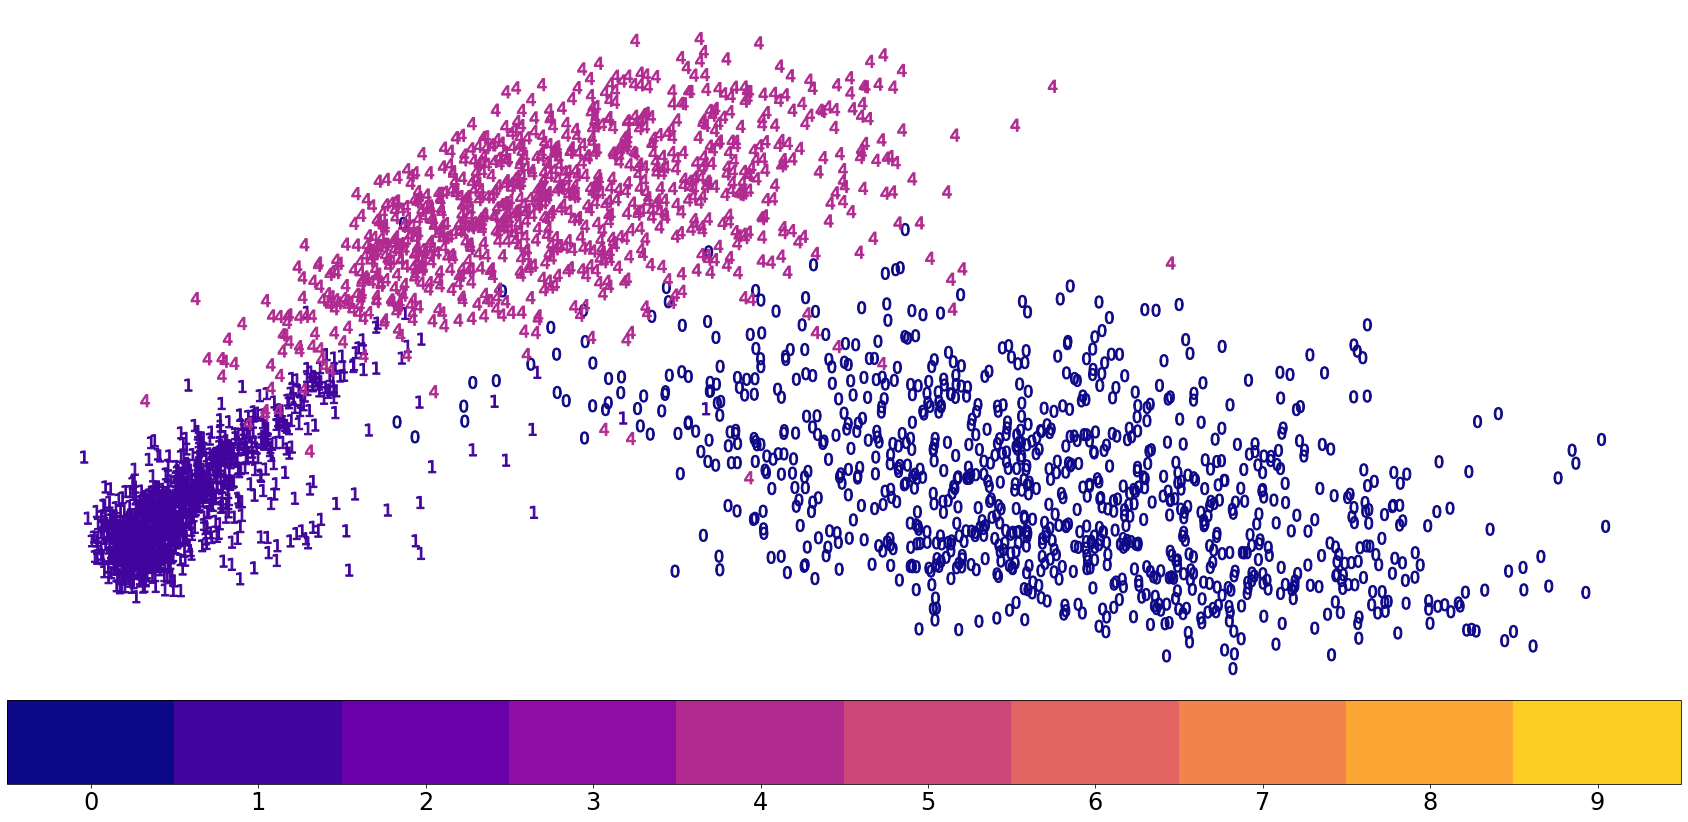

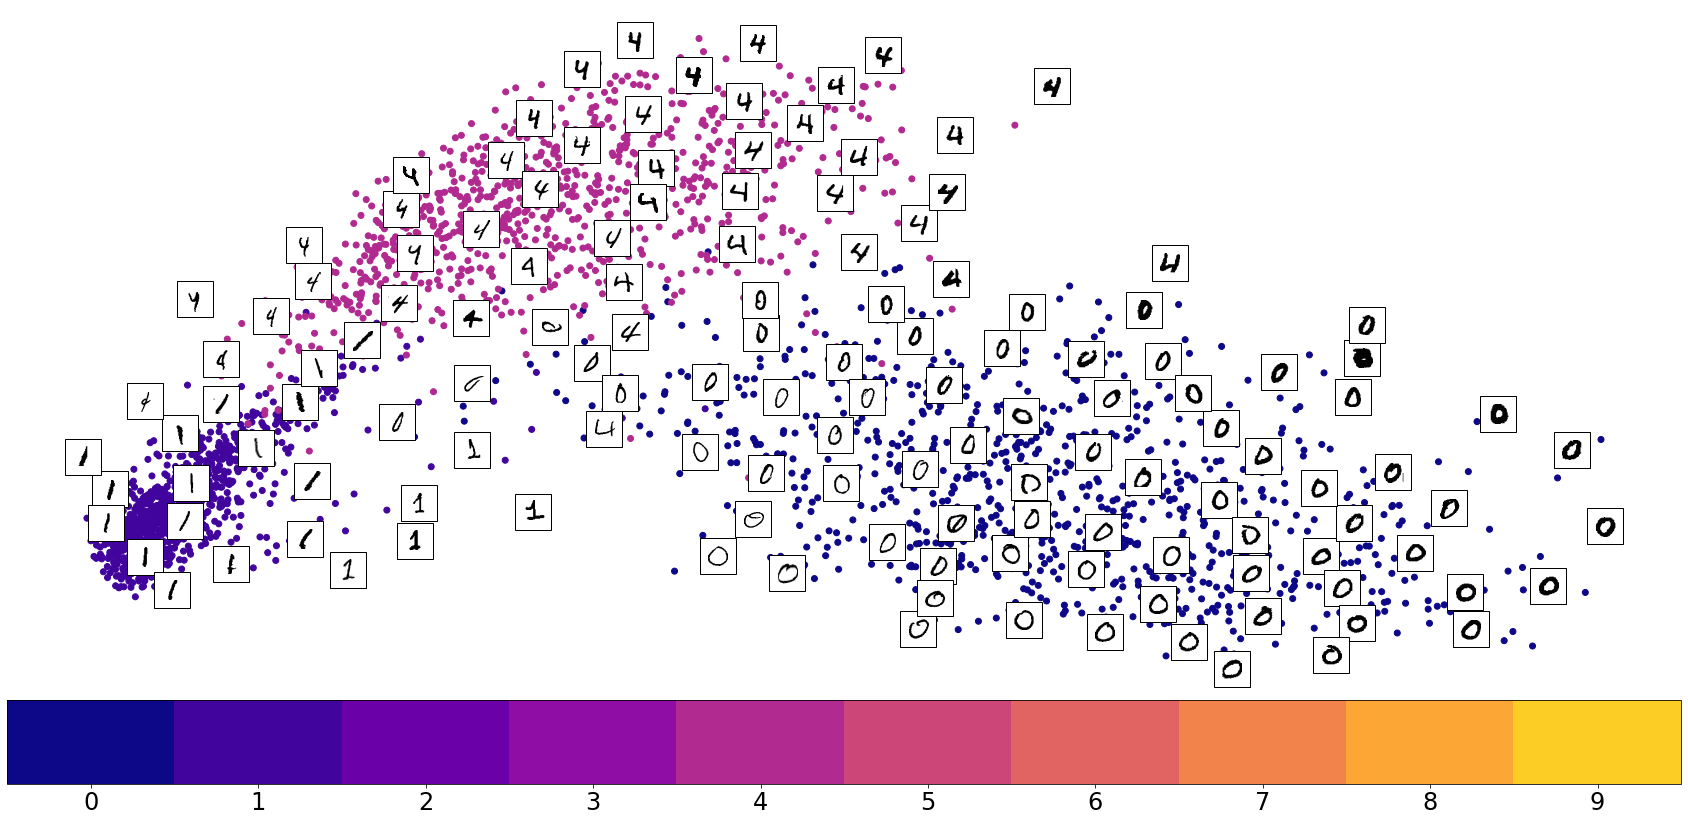

In [46]:
# only numbers
plot_digits(X_pca_reduced014, y_subset014, numbers=150, images=None, figsize=(30, 15))
# only images
plot_digits(X_pca_reduced014, y_subset014, numbers=None, images=X[idx014], figsize=(30, 15))

Im Vergleich zur PCA mit allen Ziffern ist es viel geordneter. Es gibt 3 klar erkennbare Cluster, mit wenig Überlapp. Bei den Ziffern 0, 1, 4 gibt es anscheinend keine ausgeprägte Mannigfaltigkeit. Anders sieht es natürlich aus, wenn weitere Ziffern hinzukommen. Dann gibt es wieder eine starke Überlagerung. 

**Dies ist ein anschauliches Beispiel diesbezüglich, dass der Erfolg der Feature Extraction Methode auch vom Datensatz (hier vom Subset 014 im Vergleich zu Subset 0123456789) abhängt.**

Anmerkung: Betrachten Sie auch die Visualisierung mit t-SNE von 9 und 4. Dort wurde die Mannigfaltigkeit getrennt, aber die Trennfläche von t-SNE nicht ordentlich repräsentiert (vgl. Geron 2019).

## 6 | Anhang: Technik vs. Methoden

Zeitersparnis bei anderen Techniken - ein Zeitmessbeispiel. Allerdings liefert nur die t-SNE eine zufiedenstellende Visualisierung. Mehr dazu in den folgenden Veranstaltungen.

Text(0, 0.5, 'Zeit (s)')

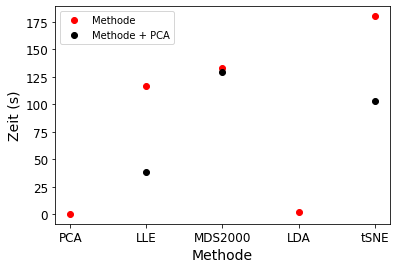

In [47]:
import matplotlib.pyplot as plt

technique_with_PCA = ['LLE', 'MDS2000', 'tSNE']
time_technique_PCA = [38.7, 129.2, 103.3]

technique = ['PCA', 'LLE', 'MDS2000','LDA', 'tSNE']
time_technique = [0.2, 116.5, 132.9, 2.0, 180.1]

plt.plot(technique, time_technique, 'or')
plt.plot(technique_with_PCA, time_technique_PCA, 'ok')

plt.legend(['Methode', 'Methode + PCA'])

plt.xlabel('Methode')
plt.ylabel('Zeit (s)')

MDS wurde auf 2000 samples im Datensatz reduziert. Sonst würde es sehr sehr lange dauern (viel länger als t-SNE).